# Point Cloud from Input Image
Using the trained monocular estimation network and the known camera intrinsic parameters, we will generate a point cloud
from an input image.

<IPython.core.display.Javascript object>


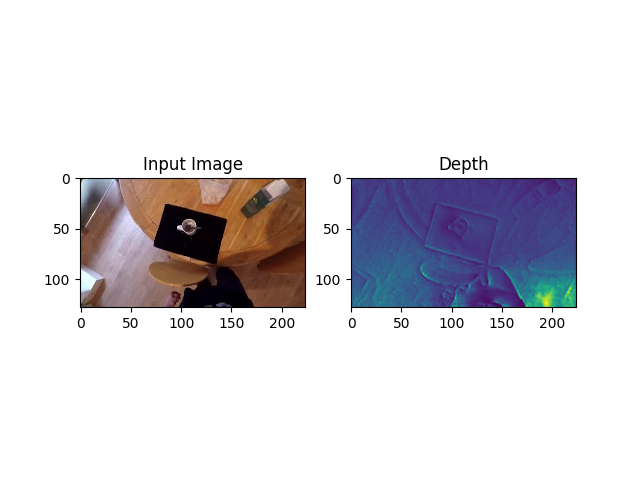

In [12]:
import numpy as np
import pandas as pd
import cv2
import json
import keras.backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.models import model_from_json
from pyntcloud import PyntCloud
import matplotlib.pyplot as plt
from inference.custom_modules import *
from inference.project import *
from inference.point_cloud_utils import *

# Load model architecture and weights
objs = {'ProjectionLayer': ProjectionLayer, 
        'ReflectionPadding2D': ReflectionPadding2D,
        'InverseDepthNormalization': InverseDepthNormalization,
        'AugmentationLayer': AugmentationLayer}
with open('../../code/trained_models/monovideo.json', 'r') as read_file:
    model_architecture_json = json.load(read_file)
    test_model = model_from_json(model_architecture_json,
                                      custom_objects=objs)
test_model.load_weights('../../code/trained_models/monovideo_weights_final.h5')
img_shape = test_model.inputs[0].shape[1:]

# Inputs-predictions
input_img = img_to_array(load_img('inference/input_frame_2.jpg')) / 255
test_data = [np.reshape(input_img, (1,)+input_img.shape),
             np.reshape(input_img, (1,)+input_img.shape),
             np.reshape(input_img, (1,)+input_img.shape)]
depth = test_model.predict(test_data)[19][0,:,:,0]

%matplotlib notebook
pretty_plotting([input_img, depth], (1,2), ['Input Image', 'Depth'])
plt.show()

In [13]:
# Intrinsics (EPIC dataset)
x_scaling = int(img_shape[1]) / 1920
y_scaling = int(img_shape[0]) / 1080
intrinsics = np.array([[1564.51*x_scaling, 0, 960*x_scaling],
                       [0, 1564.51*y_scaling, 540*y_scaling],
                       [0,0 ,1]], dtype=np.float32)
intrinsics_inv = np.linalg.inv(intrinsics)

# Create point cloud from depth and intrinsics
depth_tensor = K.variable(np.expand_dims(depth, 0))
intrinsics_inv_tensor = K.variable(np.expand_dims(intrinsics_inv, 0))
points = K.eval(get_cloud(depth_tensor, intrinsics_inv_tensor))

# Create points and colors arrays
points = np.reshape(points, points.shape[1:])
points = np.reshape(points, (points.shape[0] * points.shape[1], 3))
colors = np.reshape(input_img, (input_img.shape[0] * input_img.shape[1], 3)) * 255
## For ease of plotting, invert x and z axes
points[:,0] *= -1
points[:,2] *= -1
##
points_df = pd.DataFrame(np.concatenate((points, colors), axis=-1), 
                         columns=['x','y','z','red','green','blue'])
pc = PyntCloud(points_df)

pc.plot(initial_point_size=0.001)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.004644460044801235, 1.1218453086912632, -…